# [NTDS'18-project] Project: ???TITRE ????
[ntds'18-project]: https://github.com/rocari96/NTDS-project


#### Team: 40
[Roc Arandes Vilagrasa](https://people.epfl.ch/roc.arandes)
[Hugo Kohli](https://people.epfl.ch/hugo.kohli)
[Romain Caristan](https://people.epfl.ch/romain.caristan)
[Benoît Pasquier](https://people.epfl.ch/benoit.pasquier)



# Introduction

In this work, we want to find a way to approximate the earning of a movie, depending on the people beeing involve in it. In order to do so, we are extracting our datas from the Kaggle dataset. Several ways of constructing graph are explored to extract as much information as possible from it. The nodes of our graph are the movies, and this will be a constant all along this work. 


# Index

1. [Data loading and description](#1.-Data-description-and-loading)<br>
<br>
2. [Data pre-processing](#2.-Data-pre-processing) <br>
<br>
3. [Average earnings Model](#3.-Average-earnings-Model)<br>

    3.1 [Adjacency Matrix](#3.1-Adjacency-Matrix)
    > 3.1.1 [Biggest component](#3.1.1-Biggest-component)<br>
    > 3.1.2 [Graph visualisation on eigenmaps](#3.1.2-Graph-visualisation-on-eigenmaps)<br>
    > 3.1.3 [Analysis](#3.1.3-Analysis)<br>


4. [BRH Model](#4.-BRH-Model)

    4.1 [BRH-index computation](#4.1-Compute-BRH-Index)<br>
    4.2 [Adjacency Matrix Additioning weights](#4.2-Adjacency-matrix-additioning-weights)
    > 4.2.1 [Biggest component](#4.2.1-Biggest-component)<br>
    > 4.2.2 [Graph visualisation on eigenmaps](#4.2.2-Graph-visualisation-on-eigenmaps)<br>
    > 4.2.3 [Analysis](#4.2.3-Analysis)
    
    4.3 [BRH-index computation without companies](#4.3-BRH-index-computation-without-companies)<br>
    4.4 [Adjacency Matrix additioning BRH-index without companies](#4.4-Adjacency-Matrix-additioning-BRH-index-without-companies)<br>
    > 4.4.1 [Biggest component](#4.4.1-Biggest-component)<br>
    > 4.4.2 [Graph visualisation on eigenmaps](#4.4.2-Graph-visualisation-on-eigenmaps)<br>
    > 4.4.3 [Analysis](#4.4.3-Analysis)
    
    4.5 [Adjacency Matrix averaging BRH-index without companies](#4.5-Adjacency-Matrix-averaging-BRH-index-without-companies)<br>
    > 4.5.1 [Biggest component](#4.5.1-Biggest-component)<br>
    > 4.5.2 [Graph visualisation on eigenmaps](#4.5.2-Graph-visualisation-on-eigenmaps)<br>
    > 4.5.3 [Analysis](#4.5.3-Analysis)
    

        
5. [Conclusion](#5.-Conclusion)

In [1]:
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse.linalg
import networkx as nx
import math
from scipy import sparse

In [2]:
%matplotlib inline

In [3]:
seed = 3

---
# 1. Data description and loading 
[Back to index](#Index)

In this project we have chosed to continue to work with the [`TMDB 5000 Movie Dataset`](https://www.kaggle.com/tmdb/tmdb-movie-metadata/home) from kaggle, because it is already a subset of the more complete [`TMDB Dataset`](https://www.imdb.com/interfaces/) with less movies included, that way the computations won't be too long.

The `TMDB 5000 Movie Dataset` is composed of two source files:

**tmdb_5000_credits.csv** with the following features:
- movie_id
- title
- cast
- crew

**tmdb_5000_movies.csv** with the following features:
- budget
- genres
- homepage
- id
- keywords
- original_language
- original_title
- overview
- popularity


In [4]:
data_path = 'data/'

In [5]:
# Loading the Kaggle data
movies_path = data_path + 'tmdb-5000-movie-dataset/'
credits = pd.read_csv(movies_path + 'tmdb_5000_credits.csv')
movies = pd.read_csv(movies_path + 'tmdb_5000_movies.csv')

credits = credits.rename(columns={'movie_id': 'id'})

# merge the two data set credit and movies
movies = movies.merge(credits, how='inner', on='id')

In [6]:
movies.head(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title_x,vote_average,vote_count,title_y,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."


---
# 2. Data pre-processing
[Back to index](#Index)

The data is not complete and sometimes the unit are not consistent, therefore we need to check and remove the movies if it is the case.

In [7]:
# Check and Drop 0 budget or revenue movies (corresponds to unknown values)
before = len(movies)
movies = movies[(movies['budget'] != 0) & (movies['revenue'] != 0)]
print('{} movies were dropped ({}%).'.format(before-len(movies), 100*(before-len(movies))/before))

1574 movies were dropped (32.77118467624401%).


Additionally we create another feature for each movie that is the return on the initial investment

In [8]:
movies['earnings'] = (movies['revenue'] - movies['budget']) / movies['budget']

In [9]:
# keep only useful movies
movies = movies[['original_title', 'budget', 'revenue', 'earnings', 'production_companies', 'cast', 'crew']]
movies.head(5)

,original_title,budget,revenue,earnings,production_companies,cast,crew
0,Avatar,237000000,2787965087,10.763566,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,Pirates of the Caribbean: At World's End,300000000,961000000,2.203333,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,Spectre,245000000,880674609,2.594590,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,The Dark Knight Rises,250000000,1084939099,3.339756,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,John Carter,260000000,284139100,0.092843,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [10]:
movies.sort_values(by='earnings', ascending=False).head()

,original_title,budget,revenue,earnings,production_companies,cast,crew
4238,Modern Times,1,8500000,8.499999e+06,"[{""name"": ""United Artists"", ""id"": 60}, {""name""...","[{""cast_id"": 8, ""character"": ""A factory worker...","[{""credit_id"": ""5621aeadc3a3680e1d00a09a"", ""de..."
3137,Nurse 3-D,10,10000000,9.999990e+05,"[{""name"": ""Lions Gate"", ""id"": 6644}, {""name"": ...","[{""cast_id"": 5, ""character"": ""Abby Russell"", ""...","[{""credit_id"": ""52fe499cc3a368484e1346b1"", ""de..."
4577,Paranormal Activity,15000,193355800,1.288939e+04,"[{""name"": ""Blumhouse Productions"", ""id"": 3172}...","[{""cast_id"": 3, ""character"": ""Katie"", ""credit_...","[{""credit_id"": ""52fe4477c3a368484e024b01"", ""de..."
4582,Tarnation,218,1162014,5.329339e+03,[],"[{""cast_id"": 2, ""character"": ""Herself"", ""credi...","[{""credit_id"": ""52fe42f7c3a36847f8030443"", ""de..."
4496,The Blair Witch Project,60000,248000000,4.132333e+03,"[{""name"": ""Artisan Entertainment"", ""id"": 2188}...","[{""cast_id"": 41, ""character"": ""Mike"", ""credit_...","[{""credit_id"": ""52fe4364c3a36847f8050c01"", ""de..."


After checking some of the data, we can see that some of the values in the budget and revenue columns are expressed in millions whereas most of the values are raw numbers. We then choose to remove the values expressed in millions for more consistency of the future results. This is done by selecting only the movies that have a budget and revenue bigger than 1000 (it is yet unknown that a movie has had a budget and a revenue more than a billion dollars).

In [11]:
prev_len = len(movies)
movies = movies[(movies['budget'] > 1000) & (movies['revenue'] > 1000)].reset_index(drop=True)
n_movies = len(movies)
print(prev_len - n_movies, 100*(prev_len - n_movies)/prev_len)

18 0.5574481263549086


This deletion represents 18 movies (~0.6% of the data), which is an acceptable value.

In [12]:
movies.sort_values(by='earnings', ascending=False).head()

,original_title,budget,revenue,earnings,production_companies,cast,crew
3158,Paranormal Activity,15000,193355800,12889.386667,"[{""name"": ""Blumhouse Productions"", ""id"": 3172}...","[{""cast_id"": 3, ""character"": ""Katie"", ""credit_...","[{""credit_id"": ""52fe4477c3a368484e024b01"", ""de..."
3142,The Blair Witch Project,60000,248000000,4132.333333,"[{""name"": ""Artisan Entertainment"", ""id"": 2188}...","[{""cast_id"": 41, ""character"": ""Mike"", ""credit_...","[{""credit_id"": ""52fe4364c3a36847f8050c01"", ""de..."
3200,Eraserhead,10000,7000000,699.000000,"[{""name"": ""American Film Institute (AFI)"", ""id...","[{""cast_id"": 13, ""character"": ""Henry Spencer"",...","[{""credit_id"": ""52fe4296c3a36847f802a5dd"", ""de..."
3207,Pink Flamingos,12000,6000000,499.000000,"[{""name"": ""Dreamland Productions"", ""id"": 407}]","[{""cast_id"": 8, ""character"": ""Divine / Babs Jo...","[{""credit_id"": ""52fe426bc3a36847f801d203"", ""de..."
3202,Super Size Me,65000,28575078,438.616585,"[{""name"": ""Kathbur Pictures"", ""id"": 8735}]","[{""cast_id"": 1, ""character"": ""Himself"", ""credi...","[{""credit_id"": ""52fe44efc3a36847f80b2a9d"", ""de..."


We've chosen to only keep the 5 first actors, 5 first characters, the director, the producer and the company name. The number of actors per film that we keep is objective and could be changed. We nevertheless think that no more than the first 5 roles in a film play a preponderant role in the success of the film.

In [13]:
to_keep = 5

# extracting the data from json format
movies['actors'] = movies.cast.map(lambda x: list(map(lambda d: d['name'], json.loads(x)))[:to_keep])
movies['characters'] = movies.cast.map(lambda x: list(map(lambda d: d['character'], json.loads(x)))[:to_keep])
movies['crew'] = movies.crew.map(lambda x: list(filter(None, list(map(lambda d: d['name'] if (d['job'] == 'Director' or d['job'] == 'Producer') else None, json.loads(x))))))
movies['production_companies'] = movies.production_companies.map(lambda x: list(map(lambda d: d['name'], json.loads(x)))[:1])

# Keeping only usefull series in dataframe
movies = movies[['original_title', 'earnings', 'production_companies', 'actors', 'characters', 'crew']]
movies_no_comp = movies[['original_title', 'earnings', 'actors', 'characters', 'crew']]

# merging series in a features serie
movies['features'] = movies['production_companies'] + movies['actors'] + movies['characters'] + movies['crew']
movies_no_comp['features'] = movies_no_comp['actors'] + movies_no_comp['characters'] + movies_no_comp['crew']

# removing now useless series
movies = movies[['original_title', 'earnings', 'features']]
movies_no_comp = movies_no_comp[['original_title', 'earnings', 'features']]
movies_no_comp.head()

/home/benoit/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,original_title,earnings,features
0,Avatar,10.763566,"[Sam Worthington, Zoe Saldana, Sigourney Weave..."
1,Pirates of the Caribbean: At World's End,2.203333,"[Johnny Depp, Orlando Bloom, Keira Knightley, ..."
2,Spectre,2.594590,"[Daniel Craig, Christoph Waltz, Léa Seydoux, R..."
3,The Dark Knight Rises,3.339756,"[Christian Bale, Michael Caine, Gary Oldman, A..."
4,John Carter,0.092843,"[Taylor Kitsch, Lynn Collins, Samantha Morton,..."


In [14]:
movies['earnings'].describe()

count     3211.000000
mean        10.141042
std        240.069277
min         -0.999744
25%          0.030258
50%          1.303478
75%          3.420937
max      12889.386667
Name: earnings, dtype: float64

---
# 3. Average earnings Model
[Back to index](#Index)

In this first section, the edges are computed. The 5 first actors, 5 first characters, the director, the producer and the company name are taken in account. Doing a computation over all the movies, each people is assigned a weight, which is the average of the earnings over all the movies in which he/she contributed. Then the weight of each edge is the sum the weights of the common people between the two movies.

### Compute the weights for each feature

In [15]:
# A DataFrame where each row contains only one feature (actor, character or production company)
# Easier for later computations
earning_movies = movies.set_index(['original_title', 'earnings'])['features'].apply(pd.Series).stack().reset_index().drop('level_2', axis=1).drop_duplicates()
earning_movies.columns = ['original_title', 'earnings', 'feature']

In [16]:
earning_movies[earning_movies['feature'] == 'Christopher Nolan']

,original_title,earnings,feature
57,The Dark Knight Rises,3.339756,Christopher Nolan
216,Man of Steel,1.945980,Christopher Nolan
980,The Dark Knight,4.430046,Christopher Nolan
1403,Interstellar,3.091636,Christopher Nolan
1418,Inception,4.159580,Christopher Nolan
1777,Batman Begins,1.494791,Christopher Nolan
14396,Insomnia,1.472062,Christopher Nolan
16538,The Prestige,1.741908,Christopher Nolan
40256,Memento,3.413677,Christopher Nolan


In [17]:
def compute_features_weight(movies, data_type):
    try:
        features = pd.read_csv(data_path + 'features_' + data_type + '.csv')
    except FileNotFoundError: 
        # Create the features table with their weights associated weights (set to 0).
        features = set(movies['features'].sum())
        features.discard('')
        features = list(features)
        features.sort()
        features = pd.DataFrame(features, columns=['feature'])
        
        features['weight'] = 0
        for i, feature in enumerate(features['feature']):
            in_movie = earning_movies[earning_movies['feature'] == feature]
            features.loc[i, 'weight'] = in_movie['earnings'].sum() / len(in_movie)
            
        features.to_csv(data_path + 'features_' + data_type + '.csv')
    return features

In [18]:
features = compute_features_weight(movies, 'full')

In [19]:
features.head()

,Unnamed: 0,feature,weight
0,0,Larry Mullen Jr.,0.515389
1,1,"""Drugs"" Delaney",0.041739
2,2,"""Hickory"" / The Tin Man",11.155192
3,3,"""Hunk"" / The Scarecrow",11.155192
4,4,"""Whistling"" John Shaw",-0.487703


## 3.1 Adjacency Matrix
[Back to index](#Index)

In [20]:
def compute_adjacency(name, model, movies, features, average):
    try:
        adjacency = np.load(data_path + name)

    except FileNotFoundError: 
        adjacency = np.zeros((n_nodes, n_nodes), dtype=int)
        for i in range(n_nodes):
                # as the adjacency matrix is symmetric, only the upper triangular is calculated to save time
                for j in range(i, n_nodes):
                    # create weighted edges as the shared number of actors between movies
                    common_actors = set(movies['features'][i]).intersection(set(movies['features'][j]))
                    sum_weights = 0.0
                    counter = 0
                    for actor in common_actors :
                        if (features['feature'].isin([actor]).any()):
                            counter = counter + 1
                            sum_weights = sum_weights + features[features['feature'] == actor][model].item()
                    if (average):
                        sum_weights = sum_weigths/counter
                    adjacency[i, j] = sum_weights

        # fill the lower triangular 
        adjacency += np.transpose(adjacency)

        np.fill_diagonal(adjacency, 0, wrap=False)
        
        np.save(data_path + name, adjacency)
    return adjacency

In [21]:
n_nodes = len(movies)
adjacency = compute_adjacency('adjacency.npy', 'weight',movies,features,False)

print('Our graph contains {} movies.'.format(n_nodes))

Our graph contains 3211 movies.


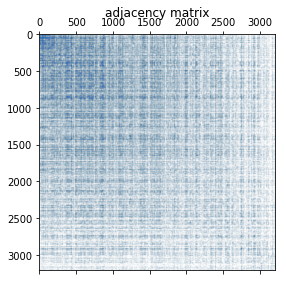

In [22]:
plt.spy(adjacency, markersize=0.01)
plt.title('adjacency matrix');
plt.tight_layout()

We first want to evaluate quickly some characteristics of our adjacency

L_max = 5153655.0
L = 353484
Sparsity = 0.9314110083038154


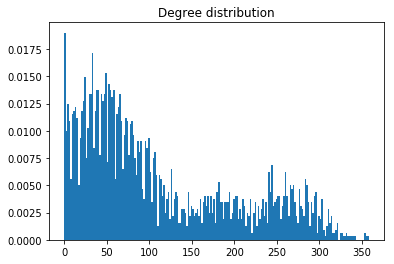

In [23]:
# maximum number of Links in our network
L_max = n_nodes*(n_nodes-1)/2
print('L_max =', L_max)

# number of link in our network
L = np.count_nonzero(adjacency)
print('L =',L)

# sparisty
sparsity = (L_max-L)/L_max
print('Sparsity =', sparsity)

# Create the binary version of adjacency matrix as our adjacency is weighted
adj_binary = adjacency.astype(bool).astype(int)
degree = np.sum(adj_binary, axis=0)

#Histogram of degree distribution
weights = np.ones_like(degree) / float(n_nodes)
plt.hist(degree, weights=weights, bins = 100);
plt.title('Degree distribution');

## 3.1.1 Biggest component
[Back to index](#Index)

In [24]:
def adj_matrix_to_list(adj):
    """Transform adjacency matrix into a dictionnary : each node is linked with all his neighbor nodes
    
    Parameters
    ----------
    adj:       adjacency matrix 
    
    Returns
    -------
    adj_list : dictionnary
    
    """
    
    adj_list = {} 
    for node, nodes in enumerate(adj):
        neighbors = []
        for next_node, weighted_edge in enumerate(nodes):
            if weighted_edge:
                neighbors.append(next_node)
        adj_list[node] = neighbors
    return adj_list

In [25]:
def bfs(adj_list, start, labels, l=1):
    
    """Apply the BFS algorithm 
    
    Parameters
    ----------
    adj_list:       Adjacency matrix transformed to a list (see ajd_matrix_to_list)
    start:          Starting node
    labels :        Information whether a node has been visited or not
    
    Returns
    -------
    labels :         contain the information whether a node has been visited or not
    bool connected : True if the graph is connected, False otherwise.
    visited :        a list of all the visited nodes
    
    """
    
    
    nodes = list(labels.keys())
    #q is a queue, it contains the next node to be inspected (initialized with the starting node)
    q = []
    q.append(start)
    #label contains for each node l (if the node has already been inspected) or 0
    labels[start] = l
    
    #while there is nodes to inspect
    while len(q):
        node = q.pop(0)
        
        #inspect all the nodes linked to 'node'
        for neighbor in adj_list[node]: 
            #if it has not already been inspected, add it to the queue, and label it to 1
            if labels[neighbor] == 0: 
                q.append(neighbor)
                labels[neighbor] = l
    #contains all the connected nodes
    visited = {node: label for (node, label) in labels.items() if label !=0} 
    connected = len(visited) == len(nodes)
    return labels, connected, visited

In [26]:
def find_components(adjacency):
    
    """Find the connected components of a graph.
    
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    
    Returns
    -------
    list of numpy arrays
        A list of adjacency matrices, one per connected component.
    """
    components = list()
    # transform the adjacency matrix into an adjacency list where the weights are ignored
    adj_list = adj_matrix_to_list(adjacency) 
    
    # l: the label of the components
    l = 1
    
    # select a random node to start exploring the graph
    start = np.random.choice(list(adj_list.keys()))
    nodes = list(adj_list.keys())
    
    # apply BFS to label the nodes of the first component and to know if the graph is connected
    labels, visited_all, _ = bfs(adj_list, start, {node: 0 for node in nodes})
    visited = [node for node, label in labels.items() if label == l]
    components.append(adjacency[visited, :][:, visited]) 
    
    # while we did not label every node
    while not visited_all:
        l += 1
        to_visit = [node for node, label in labels.items() if label == 0]
        start = np.random.choice(list(to_visit))
        # apply new BFS to explore new component
        labels, visited_all,_ = bfs(adj_list, start, labels, l)
        visited = [node for node, label in labels.items() if label == l]
        components.append(adjacency[visited, :][:, visited]) 
    
    # the list of all components sorted by descending size 
    components.sort(key=lambda mat: mat.shape, reverse=True)    
    return components, labels

In [27]:
def compute_bc(name, adjacency):
    try:
        bc_nparray = np.load(data_path + name)
        nodes_bc = np.load(data_path + 'nodes_' + name)
    
    except FileNotFoundError:
        components, labels = find_components(adjacency)
        bc_nparray = components[0]
        label_count = np.unique(np.fromiter(labels.values(), dtype=int), return_counts=True)
        lab_dict = dict(zip(label_count[0], label_count[1]))
        label_bc = max(lab_dict, key=lab_dict.get)
        nodes_bc = [node for node, label in labels.items() if label == label_bc]
        np.save(data_path + name, bc_nparray)
        np.save(data_path + 'nodes_' + name, nodes_bc)

    return bc_nparray, nodes_bc

In [28]:
bc_nparray, nodes_bc = compute_bc('bc', adjacency)

n_nodes_bc = len(nodes_bc)

print('The size of the largest component is {}.'.format(n_nodes_bc))

The size of the largest component is 3167.


In [29]:
G = nx.from_numpy_array(bc_nparray)

print('Clustering coefficient of our Biggest Component =' ,nx.average_clustering(G))

Clustering coefficient of our Biggest Component = 0.4873697052213142


In [30]:
movies_bc = movies.loc[nodes_bc, :]
movies_bc['earnings'].describe()

count     3167.000000
mean        10.252519
std        241.728974
min         -0.999744
25%          0.047413
50%          1.320008
75%          3.422960
max      12889.386667
Name: earnings, dtype: float64

# 3.1.2 Graph visualisation on eigenmaps
[Back to index](#Index)

In [31]:
def compute_gradient_laplacian(name, bc_nparray, degree_biggest_component, N, E):
    try:
        gradient = scipy.sparse.load_npz(data_path + name)
        sparse_gradient = sparse.csr_matrix(gradient)

    except FileNotFoundError:
        # Let us compute the gradient
        gradient = np.zeros((E, N))
        eij = 0  # edge index

        for i in range(N):
            for j in range(N):
                wij = bc_nparray[i, j]
                if wij > 0:
                    gradient[eij,i] = math.sqrt(wij)/math.sqrt(2*degree_biggest_component[i])
                    gradient[eij,j] = -math.sqrt(wij)/math.sqrt(2*degree_biggest_component[j])
                    eij = eij + 1  # increment the edge index 
        sparse_gradient = sparse.csr_matrix(gradient)
        scipy.sparse.save_npz(data_path + name, sparse_gradient)
        
    laplacian = (gradient.T@gradient) #Laplacian Normalisé calculé avec le gradient.
    sparse_laplacian = sparse.csr_matrix(laplacian)
        
    return sparse_gradient, sparse_laplacian

In [32]:
degree_biggest_component= np.sum(bc_nparray, axis=0)

N = n_nodes_bc  # number of nodes
E = np.sum(bc_nparray > 0)  # number of edges (non-zero entries of A)

sparse_gradient, sparse_laplacian = compute_gradient_laplacian('gradient.npz', bc_nparray, degree_biggest_component, N, E)   

In [33]:
eigenvalues, eigenvectors = np.linalg.eigh(sparse_laplacian.toarray())
e = eigenvalues
U = eigenvectors

D = np.diag(degree_biggest_component)
D_inv = np.divide(1,D)
D_inv[D_inv == np.inf] = 0
D_sqrtinv = scipy.linalg.sqrtm(D_inv)

#Renormalized by the degrees
U_norm = D_sqrtinv@U

# Normalize the rows of U_norm
rows_norm = np.linalg.norm(U_norm, axis=1, ord=2)
U_norm = (U_norm.T / rows_norm).T

/home/benoit/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


/home/benoit/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/numpy/core/numeric.py:553: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)
/home/benoit/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/benoit/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


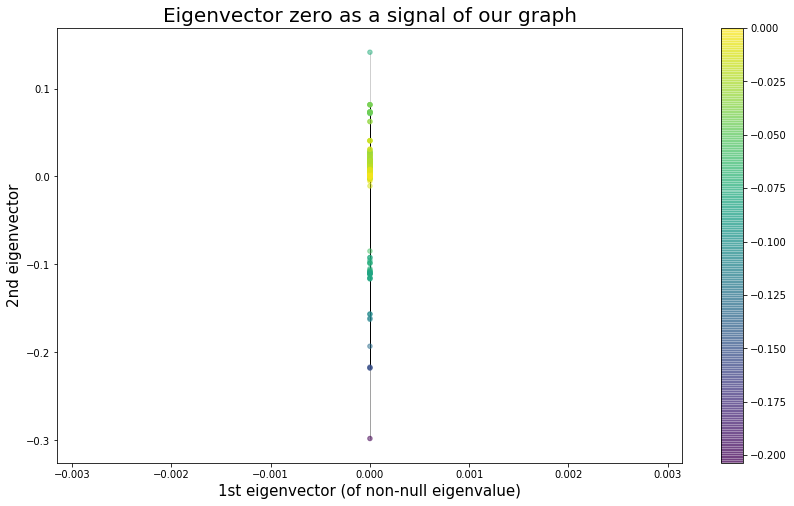

In [34]:
plt.figure(figsize=(14,8))
coords = U_norm[:,1:3]
nx_nodes = nx.draw_networkx_nodes(G, coords,alpha=0.5, node_size=20, node_color=U_norm[:,0])
nx.draw_networkx_edges(G, coords, alpha=0.01)
plt.title('Eigenvector zero as a signal of our graph', fontsize=20)
plt.xlabel('1st eigenvector (of non-null eigenvalue)', fontsize=15)
plt.ylabel('2nd eigenvector', fontsize=15)
plt.colorbar(nx_nodes);

### Signal creation

As a first approach, we choose to use binary labels as our signal. A threshold is used to separate the earnings in a true (earning bigger than the threshold) or false (earning smaller than the threshold) signal. Different threshold values are  explored and the corresponding signal will be observed on the graph.

In [35]:
label_threshold = 2

In [36]:
#Creation of binary labels, depending on the "earning threshold"
def labels_creation(threshold):
    labels = np.zeros(n_nodes_bc, dtype=float)
    labels[movies_bc['earnings'] >= threshold] = 1
    labels[movies_bc['earnings'] < threshold] = -1
    return labels

In [37]:
labels_bc = labels_creation(label_threshold)
lab_bc_count = np.unique(labels_bc, return_counts=True)
dict(zip(lab_bc_count[0], lab_bc_count[1]))

{-1.0: 1907, 1.0: 1260}

### Fourier analysis

In order to visualize best the labels on the graph, we show them on eigenmaps composed by each the combinations of the three eigenvectors that have the highest correlation with the labels. These eigenvectors can be found using the GFT of the labels.

In [38]:
def GFT(x,N,U_norm):
    gft = np.zeros(N)
    for i in range(N):
        gft[i] = np.dot(x,U_norm[:,i])
    return gft 

def iGFT(x,N,U_norm):
    igft = np.zeros(N)
    for i in range(N):
            igft[i] += np.dot(x,U_norm[i,:])
    return igft

/home/benoit/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/ipykernel_launcher.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  after removing the cwd from sys.path.


<StemContainer object of 3 artists>

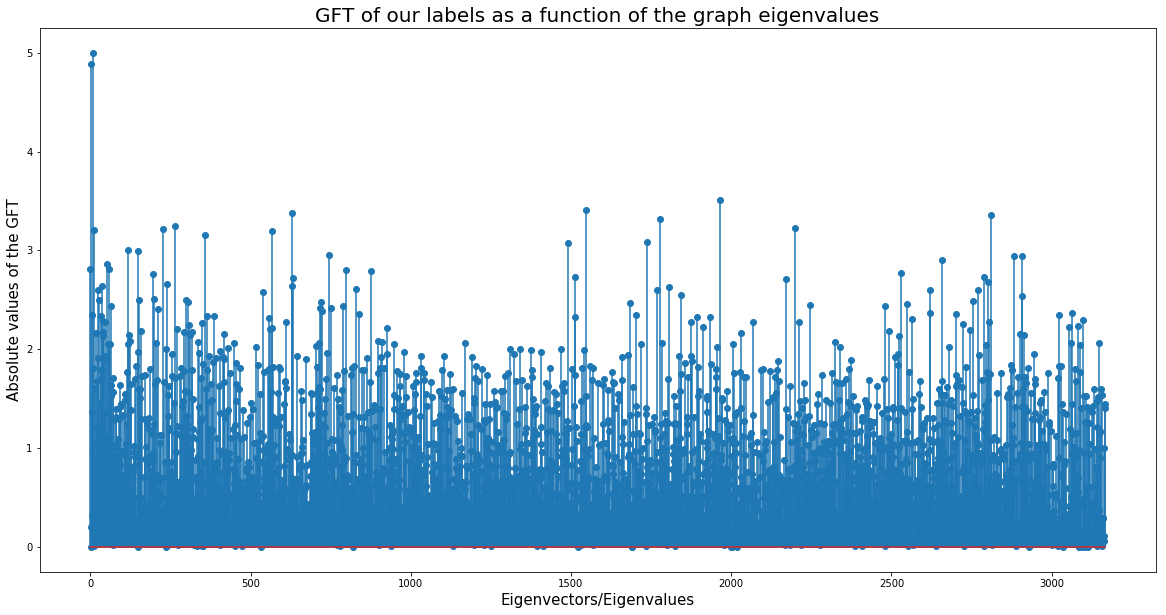

In [39]:
gft = GFT(labels_bc,N,U_norm)

gft_abs = abs(gft)
plt.figure(figsize=(20,10))
plt.title('GFT of our labels as a function of the graph eigenvalues', fontsize=20)
plt.xlabel('Eigenvectors/Eigenvalues', fontsize=15)
plt.ylabel('Absolute values of the GFT', fontsize=15)

plt.stem(gft_abs)

## 3.1.3 Analysis
[Back to index](#Index)

### Visualisation of the signal on laplacian eigenmaps with most representative vectors

In [40]:
# getting the indexes of the eigenvectors with the highest amplitude
index_eig = gft_abs.argsort()[-10:][::-1]
index_eig

array([   8,    2, 1966, 1546,  630, 2812, 1778,  263, 2200,  226])

/home/benoit/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/numpy/core/numeric.py:553: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)
/home/benoit/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/benoit/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


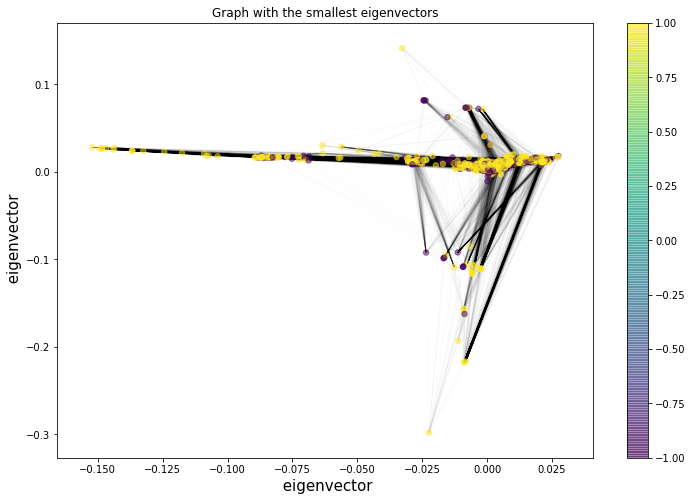

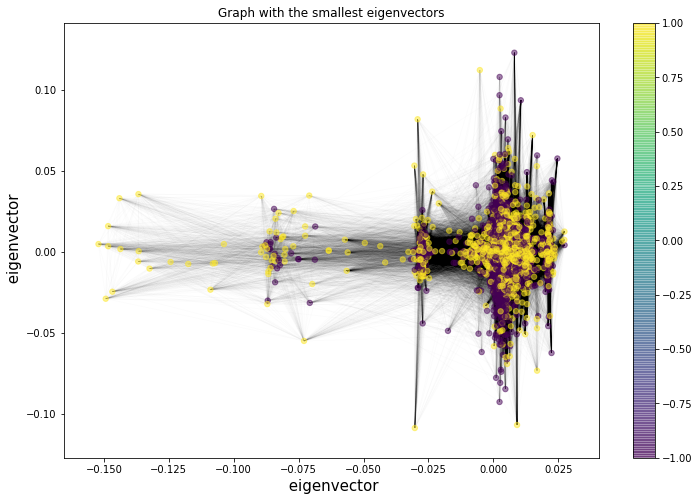

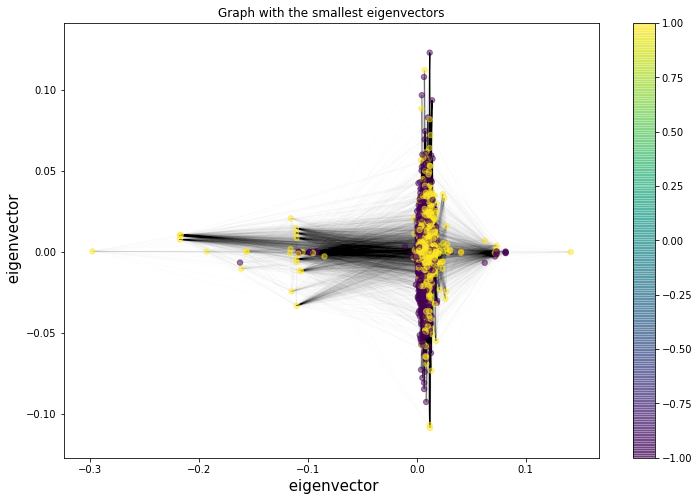

In [41]:
for i in range(3):
    for j in range(i+1,3):
        plt.figure(figsize=(12,8))
        coords = U_norm[:,[index_eig[i], index_eig[j]]]
        nx_nodes = nx.draw_networkx_nodes(G, coords,alpha=0.5 ,node_size=29, node_color=labels_bc)
        nx.draw_networkx_edges(G, coords, alpha=0.01)
        plt.title('Graph with the smallest eigenvectors')
        plt.xlabel(' eigenvector', fontsize=15);
        plt.ylabel(' eigenvector', fontsize=15);
        plt.colorbar(nx_nodes);

As we can see on these plots, the first way of creating a graph does not seems to be appropriate to answer our initial question.
Indeed, apart from some outliers that are distant the others, there is no clear cluster in our graph. The nodes are just huddled in a big group, and therefore, regardless of the threshold used to create the labels, no information about the earning can be drawn from the graph.

This model has one big inconvenient, which could be the reason why the earnings cannot be extracted at all. Indeed, if a person played in a single movie who had a very big income compared to its budget, the weight of this person is very high.

For example, the movie "Paranormal Activity" is the movie with the biggest earning in this dataset, therefore, Amber Amstrong who played in this movie, is the person with the highest weight of all the people among all the films, even bigger than Brad Pitt for example. However, she's far from being the most famous actress, and one can reasonnably think that its impact in a movie cannot be as important as its computed weight suggests. 

From this point, we thought about another way to attribute a weight to the edges, which is described in details in the following section.


---
# 4. BRH Model
[Back to index](#Index)

As we could see in the previous section, we were not able to extract any remarkable information using the weights obtained with the previously introduced mathematical model. Therefore, we decided to create a novel way of computing an index that represents somehow the economical impact that an actor/character/director/company has when participating in a movie production. 

In order to do so, we were inspired by the mathematical model "h-index" used in the scientific community to measure the impact of the creations (papers) of a scientist. 

We named our model: BRH-Index. 

Each person and company is being assigned to a brh_index, and the edges represent then the sum of the h-indexes of all the common actors between the two movies.

This model attempts to better represent the real economic impact of an individual person, giving less importance to people such as Amber Armstrong who only appear in one successful movie.

## 4.1 Compute BRH Index
[Back to index](#Index)

In [42]:
# BRH_index created and owned by BRH Index Corp. MIT License. For business inquires, please contact our secretary Romain le BG
def brh_index_calculator(name):
    
    
    """Apply the BRH index algorithm 
    
    Parameters
    ----------
    name: name of the actor/character/production company
    
    Returns
    -------
    brh_index : quantify the impact of a feature as a function of the revenue of the films in which it was involved
 
    """
    
    
    brh_index = 0
    brh_index_p = 0
    brh_index_n = 0
    
    earnings_feature = pd.DataFrame(earning_movies[earning_movies['feature'] == name]['earnings'])
    
    positive_earnings = earnings_feature[earnings_feature > 0].dropna().sort_values(['earnings'], ascending = False)
    positive_earnings = 100*positive_earnings.reset_index(drop=True)



    if (len(positive_earnings['earnings']) == 1):
        if (positive_earnings['earnings'][0] >= 1):
            brh_index_p = 1
        else:
            brh_index_p = round(positive_earnings['earnings'][0])
    else:
        for i in range(len(positive_earnings['earnings'])) :
            if len(positive_earnings[positive_earnings['earnings'] >= positive_earnings['earnings'][i]]) >= round(positive_earnings['earnings'][i]) :
                brh_index_p = i
                break
        

    negative_earnings = earnings_feature[earnings_feature < 0].dropna().sort_values(['earnings'], ascending = True)
    negative_earnings = negative_earnings.reset_index(drop=True)
    negative_earnings = 100* abs(negative_earnings)

    if (len(negative_earnings['earnings']) == 1):
        if (negative_earnings['earnings'][0] >= 1):
            brh_index_n = 1
        else:
            brh_index_n = round(negative_earnings['earnings'][0])
    else:
        for i in range(len(negative_earnings['earnings'])) :
            if len(negative_earnings[negative_earnings['earnings'] >= negative_earnings['earnings'][i]]) >= round(negative_earnings['earnings'][i]) :
                brh_index_n = i
                break
        

    brh_index = brh_index_p - brh_index_n
    return brh_index

In [43]:
def compute_features_brh(movies, data_type):
    try:
        features = pd.read_csv(data_path + 'features_brh_' + data_type + '.csv')
    except FileNotFoundError: 
        # Create the features table with their weights associated weights (set to 0).
        features = set(movies['features'].sum())
        features.discard('')
        features = list(features)
        features.sort()
        features = pd.DataFrame(features, columns=['feature'])
        
        features['brh_index'] = features['feature'].apply(lambda f: brh_index_calculator(f))
        features['brh_index'] = features['brh_index'] + abs(min(features['brh_index']))
        
        features.to_csv(data_path + 'features_brh_' + data_type + '.csv')
    return features

In [44]:
features = pd.concat([features, compute_features_brh(movies, 'full')['brh_index']], axis=1)

In [45]:
features.head()

,Unnamed: 0,feature,weight,brh_index
0,0,Larry Mullen Jr.,0.515389,11.0
1,1,"""Drugs"" Delaney",0.041739,11.0
2,2,"""Hickory"" / The Tin Man",11.155192,11.0
3,3,"""Hunk"" / The Scarecrow",11.155192,11.0
4,4,"""Whistling"" John Shaw",-0.487703,9.0


In [46]:
features.sort_values(by='brh_index', ascending=False)
features[features['feature'] == 'James Bond']

,Unnamed: 0,feature,weight,brh_index
10335,10335,James Bond,12.546743,10.0


In [47]:
features.sort_values(by='brh_index', ascending=False).head(20)

,Unnamed: 0,feature,weight,brh_index
23505,23505,Universal Pictures,3.901744,123.0
17856,17856,Paramount Pictures,4.439880,114.0
23392,23392,Twentieth Century Fox Film Corporation,3.778530,105.0
4573,4573,Columbia Pictures,1.878315,94.0
17181,17181,New Line Cinema,8.538247,81.0
23882,23882,Walt Disney Pictures,2.663880,72.0
23503,23503,United Artists,10.830685,59.0
6635,6635,DreamWorks SKG,2.315972,47.0
7818,7818,Fox Searchlight Pictures,4.725724,45.0
23716,23716,Village Roadshow Pictures,1.475530,42.0


## 4.2 Adjacency matrix additioning weights
[Back to index](#Index)

The first naive approach with the new feature weigths to calculate edgesis to simply add all brh_index of the common features between the two movies

In [48]:
adjacency_brh = compute_adjacency('adjacency_brh.npy', 'brh_index',movies, features, False)

L_max = 5153655.0
L = 353484
Sparsity = 0.9280308829364791


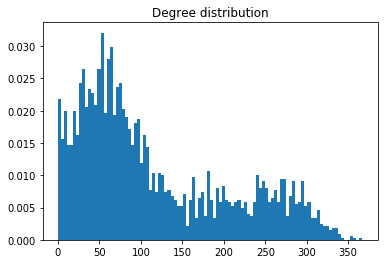

In [49]:
# maximum number of Links in our network
L_max_brh = n_nodes*(n_nodes-1)/2
print('L_max =', L_max_brh)

# number of link in our network
L_brh = np.count_nonzero(adjacency_brh)
print('L =',L)

# sparisty
sparsity_brh = (L_max_brh-L_brh)/L_max_brh
print('Sparsity =', sparsity_brh)

# Create the binary version of adjacency matrix as our adjacency is weighted
adj_binary_brh = adjacency_brh.astype(bool).astype(int)
degree_brh =  np.sum(adj_binary_brh, axis=0)

#Histogram of degree distribution
weights_brh = np.ones_like(degree_brh) / float(n_nodes)
plt.hist(degree_brh, weights=weights_brh, bins = 100);
plt.title('Degree distribution');

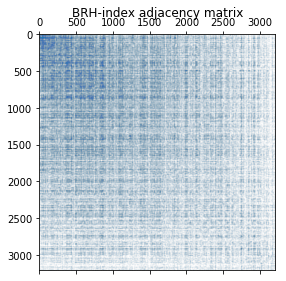

In [50]:
plt.spy(adjacency_brh, markersize=0.01)
plt.title('BRH-index adjacency matrix');
plt.tight_layout()

## 4.2.1 Biggest component
[Back to index](#Index)

In [51]:
bc_nparray_brh, nodes_bc_brh = compute_bc('bc_nparray.npy', adjacency_brh)

In [52]:
n_nodes_bc_brh = len(nodes_bc_brh)

print('The size of the largest component is {}.'.format(n_nodes_bc_brh))

The size of the largest component is 3190.


In [53]:
G_brh = nx.from_numpy_array(bc_nparray_brh)

print('Clustering coefficient of our Biggest Component =' ,nx.average_clustering(G_brh))

Clustering coefficient of our Biggest Component = 0.4384346762438128


In [54]:
movies_bc_brh = movies.loc[nodes_bc_brh, :]
movies_bc_brh['earnings'].describe()

count     3190.000000
mean        10.175036
std        240.857409
min         -0.999744
25%          0.030190
50%          1.301942
75%          3.413405
max      12889.386667
Name: earnings, dtype: float64

## 4.2.2 Graph visualisation on eigenmaps
[Back to index](#Index)

In [55]:
degree_biggest_component_brh= np.sum(bc_nparray_brh, axis=0)

N_brh = n_nodes_bc_brh  # number of nodes
E_brh = np.sum(bc_nparray_brh > 0)  # number of edges (non-zero entries of A)

sparse_gradient_brh, sparse_laplacian_brh = compute_gradient_laplacian('gradient_brh.npz', bc_nparray_brh, degree_biggest_component_brh, N_brh, E_brh)

In [56]:
eigenvalues_brh, eigenvectors_brh = np.linalg.eigh(sparse_laplacian_brh.toarray())
e_brh = eigenvalues_brh
U_brh = eigenvectors_brh

D_brh = np.diag(degree_biggest_component_brh)
D_inv_brh = np.divide(1,D_brh)
D_inv_brh[D_inv_brh == np.inf] = 0
D_sqrtinv_brh = scipy.linalg.sqrtm(D_inv_brh)

#Renormalized by the degrees
U_norm_brh = D_sqrtinv_brh@U_brh

# Normalize the rows of U_norm
rows_norm_brh = np.linalg.norm(U_norm_brh, axis=1, ord=2)
U_norm_brh = (U_norm_brh.T / rows_norm_brh).T

/home/benoit/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


/home/benoit/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


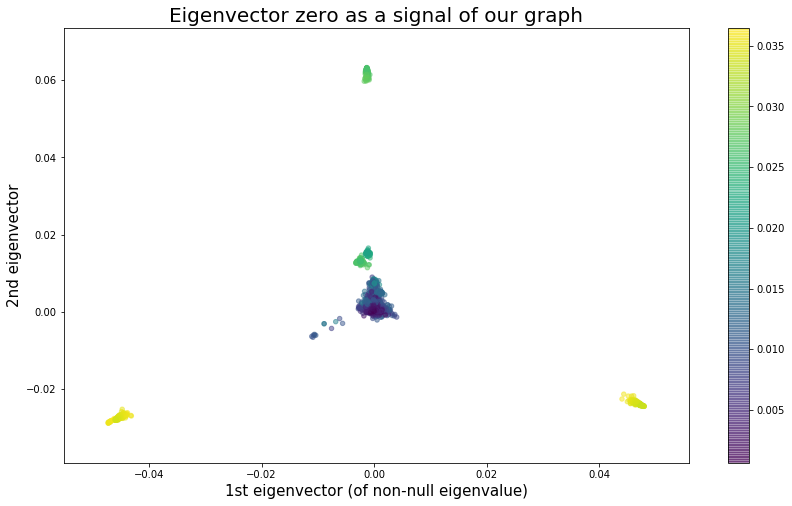

In [57]:
plt.figure(figsize=(14,8))
coords = U_norm_brh[:,1:3]
nx_nodes = nx.draw_networkx_nodes(G_brh, coords,alpha=0.5, node_size=20, node_color=U_norm_brh[:,0])
nx.draw_networkx_edges(G_brh, coords, alpha=0.0001)
plt.title('Eigenvector zero as a signal of our graph', fontsize=20)
plt.xlabel('1st eigenvector (of non-null eigenvalue)', fontsize=15)
plt.ylabel('2nd eigenvector', fontsize=15)
plt.colorbar(nx_nodes);

When visualizing the graph on the eigenmap composed by the two smallest eigenvectors (eigenvector 0 excepted), on can clearly identify at least 5 major clusters. 3 clusters are especially interesting, the one at the extremities of the graph. Indeed, they form an equilateral triangle, meaning that the repulsion between them is maximal.

These clusters being so clear, we will want to investigate the common features between them.

### Signal creation

In [58]:
label_threshold = 2.5

In [59]:
#Creation of binary labels, depending on the "earning threshold"
def labels_creation_brh(threshold):
    labels = np.zeros(n_nodes_bc_brh, dtype=float)
    labels[movies_bc_brh['earnings'] >= threshold] = 1
    labels[movies_bc_brh['earnings'] < threshold] = -1
    return labels

In [60]:
labels_bc_brh = labels_creation_brh(label_threshold)
lab_bc_count_brh = np.unique(labels_bc_brh, return_counts=True)
dict(zip(lab_bc_count_brh[0], lab_bc_count_brh[1]))

{-1.0: 2133, 1.0: 1057}

### Fourier analysis

<StemContainer object of 3 artists>

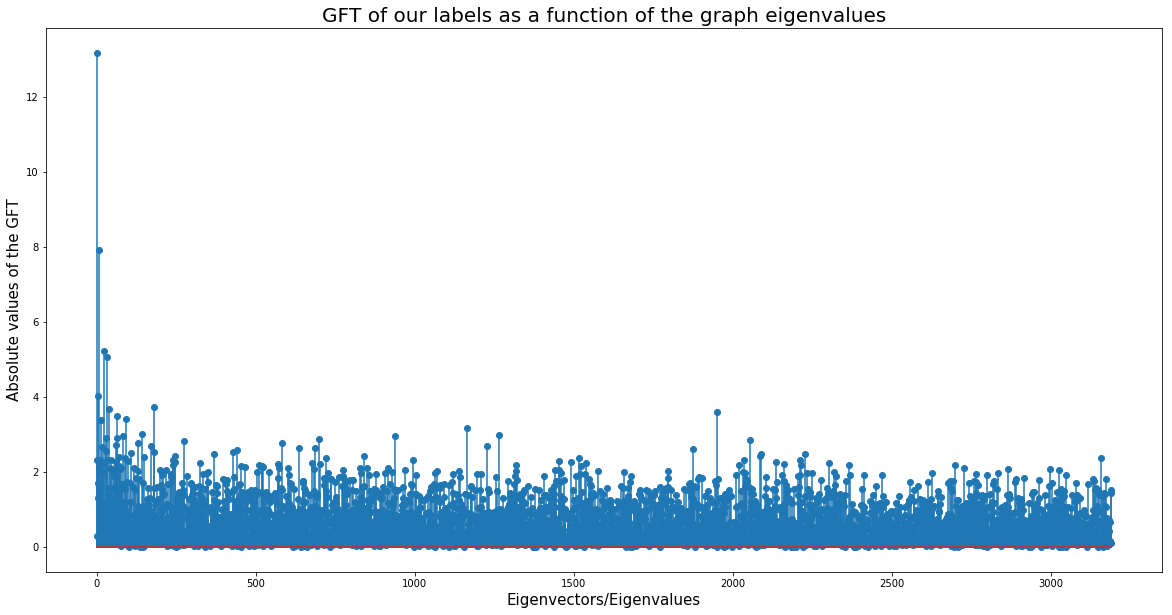

In [61]:
gft = GFT(labels_bc_brh, N_brh, U_norm_brh)

gft_abs = abs(gft)
plt.figure(figsize=(20,10))
plt.title('GFT of our labels as a function of the graph eigenvalues', fontsize=20)
plt.xlabel('Eigenvectors/Eigenvalues', fontsize=15)
plt.ylabel('Absolute values of the GFT', fontsize=15)

plt.stem(gft_abs)

## 4.2.3 Analysis
[Back to index](#Index)

### Visualisation of the signal on laplacian eigenmaps with most representative vectors

/home/benoit/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


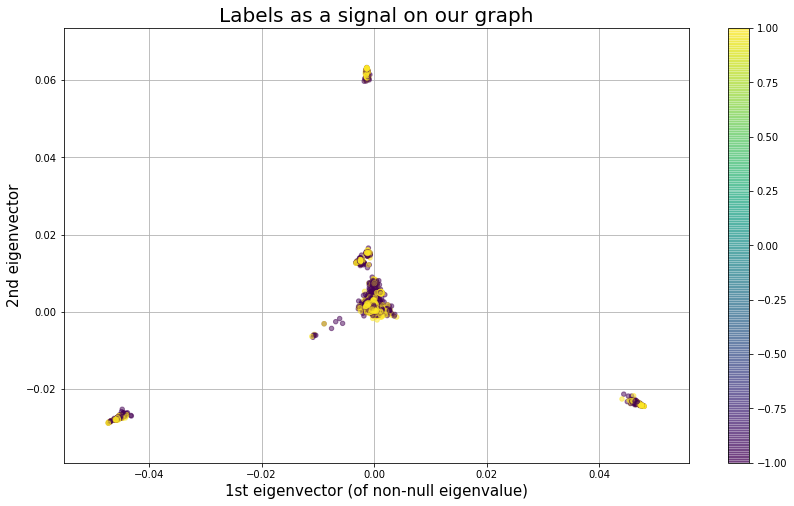

In [62]:
plt.figure(figsize=(14,8))
coords = U_norm_brh[:,1:3]
nx_nodes = nx.draw_networkx_nodes(G_brh, coords,alpha=0.5, node_size=20, node_color=labels_bc_brh)
nx.draw_networkx_edges(G_brh, coords, alpha=0.0001)
plt.title('Labels as a signal on our graph', fontsize=20)
plt.xlabel('1st eigenvector (of non-null eigenvalue)', fontsize=15)
plt.ylabel('2nd eigenvector', fontsize=15)
plt.colorbar(nx_nodes);
plt.grid()

## Checking the common features of the clusters

The investigation on the content of the clusters is done manullay, taking into account its location on the eigenmap representation.

In [63]:
# Manual check of which of the features are commun within bottom left cluster
list_of_list = np.argwhere(U_norm_brh[:,1]<-0.04).tolist()
flat_list = [item for sublist in list_of_list for item in sublist]
cluster = movies_bc_brh.iloc[flat_list]
cluster.features

# Check the percentages of the movies in the cluster which have been produce by Universal Pictures
subset_wanted = {"Universal Pictures"}
count = cluster.features.apply(subset_wanted.issubset).sum()
percentage = count/len(cluster.features)*100
print("The studied cluster is composed of {} % movies produced by {}" .format(percentage, subset_wanted))

The studied cluster is composed of 100.0 % movies produced by {'Universal Pictures'}


In [64]:
# Manual check of which of the features are commun within bottom right cluster
list_of_list = np.argwhere(U_norm_brh[:,1]>0.04).tolist()
flat_list = [item for sublist in list_of_list for item in sublist]
cluster = movies_bc_brh.iloc[flat_list]
cluster.features

# Check the percentages of the movies in the cluster which have been produce by Paramount Pictures
subset_wanted = {"Paramount Pictures"}
count = cluster.features.apply(subset_wanted.issubset).sum()
percentage = count/len(cluster.features)*100
print("The studied cluster is composed of {} % movies produced by {}" .format(percentage, subset_wanted))

The studied cluster is composed of 100.0 % movies produced by {'Paramount Pictures'}


In [65]:
# Manual check of which of the features are commun within Top cluster
list_of_list = np.argwhere(U_norm_brh[:,2]>0.04).tolist()
flat_list = [item for sublist in list_of_list for item in sublist]
cluster = movies_bc_brh.iloc[flat_list]
cluster.features

# Check the percentages of the movies in the cluster which have been produce by Twentieth Century Fox Film Corporation
subset_wanted = {"Twentieth Century Fox Film Corporation"}
count = cluster.features.apply(subset_wanted.issubset).sum()
percentage = count/len(cluster.features)*100
print("The studied cluster is composed of {} % movies produced by {}" .format(percentage, subset_wanted))

The studied cluster is composed of 100.0 % movies produced by {'Twentieth Century Fox Film Corporation'}


We clearly see that all movies from the most defined cluster are movies produced by the top 3 Production companies. This means that the weigth of the companies is way too much important compared to single individuals, and therefore they bias completely the whole graph. 

## Labels representation

Nonetheless, we try to show the labels on this graph, on the eigenmap composed by the two eigenvectors that represent best our labels.

In [66]:
# getting the indexes of the eigenvectors with the highest amplitude
index_eig = gft_abs.argsort()[-10:][::-1]
index_eig

array([   0,    8,   22,   32,    4,  181,   38, 1949,   63,   91])

/home/benoit/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


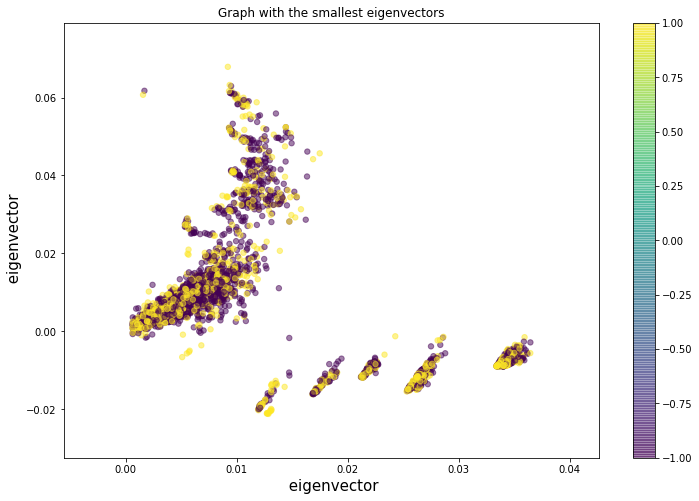

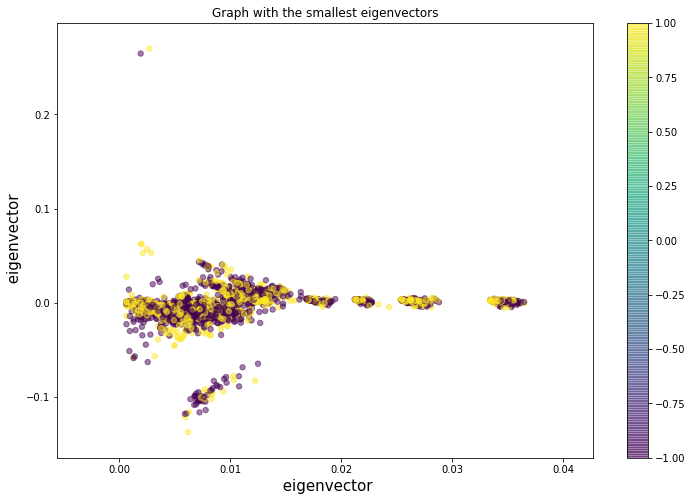

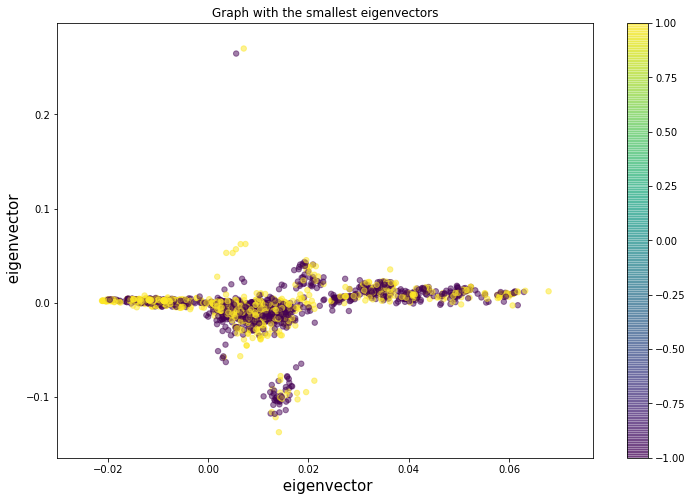

In [67]:
for i in range(3):
    for j in range(i+1,3):
        plt.figure(figsize=(12,8))
        coords = U_norm_brh[:,[index_eig[i], index_eig[j]]]
        nx_nodes = nx.draw_networkx_nodes(G_brh, coords,alpha=0.5 ,node_size=29, node_color=labels_bc_brh)
        nx.draw_networkx_edges(G_brh, coords, alpha=0.0001)
        plt.title('Graph with the smallest eigenvectors')
        plt.xlabel(' eigenvector', fontsize=15);
        plt.ylabel(' eigenvector', fontsize=15);
        plt.colorbar(nx_nodes);

These plots show that even the eigenmaps that best represent our signal does not represent it.

## 4.3 BRH-index computation without companies
[Back to index](#Index)

In [68]:
features_no_comp = compute_features_weight(movies_no_comp, 'no_comp')

In [69]:
features_no_comp.head()

,Unnamed: 0,feature,weight
0,0,Larry Mullen Jr.,0.515389
1,1,"""Drugs"" Delaney",0.041739
2,2,"""Hickory"" / The Tin Man",11.155192
3,3,"""Hunk"" / The Scarecrow",11.155192
4,4,"""Whistling"" John Shaw",-0.487703


In [70]:
features_no_comp = pd.concat([features_no_comp, compute_features_brh(movies_no_comp, 'no_comp')['brh_index']], axis=1)

In [71]:
features_no_comp.head()

,Unnamed: 0,feature,weight,brh_index
0,0,Larry Mullen Jr.,0.515389,11.0
1,1,"""Drugs"" Delaney",0.041739,11.0
2,2,"""Hickory"" / The Tin Man",11.155192,11.0
3,3,"""Hunk"" / The Scarecrow",11.155192,11.0
4,4,"""Whistling"" John Shaw",-0.487703,9.0


In the DataFrame `feature_no_comp` we now have the table of features (actors, characters, directors and producers) without the companies (such as Universal, New Line Cinema, etc)

In [72]:
features_no_comp.sort_values(by='brh_index', ascending=False).head(10)

,Unnamed: 0,feature,weight,brh_index
11167,11167,Joel Silver,1.592479,41.0
2570,2570,Brad Pitt,2.236545,41.0
21367,21367,Steven Spielberg,8.786479,41.0
22170,22170,Tim Bevan,2.616512,37.0
3044,3044,Cameron Diaz,3.241141,36.0
7092,7092,Eric Fellner,2.667155,36.0
20247,20247,Scott Rudin,1.914505,36.0
22364,22364,Tom Hanks,5.591047,36.0
16213,16213,Morgan Freeman,2.868493,36.0
8151,8151,George Clooney,2.097404,36.0


## 4.4 Adjacency Matrix additioning BRH-index without companies
[Back to index](#Index)

In [73]:
adjacency_brh_no_comp = compute_adjacency('adjacency_brh_no_comp.npy', 'brh_index', movies_no_comp, features_no_comp, False)

L_max = 5153655.0
L = 157300
Sparsity = 0.9694779724292759


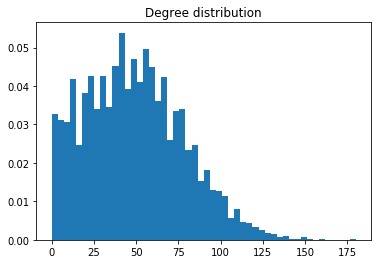

In [74]:
# maximum number of Links in our network
L_max_brh_no_comp = n_nodes*(n_nodes-1)/2
print('L_max =', L_max_brh_no_comp)

# number of link in our network
L_brh_no_comp = np.count_nonzero(adjacency_brh_no_comp)
print('L =',L_brh_no_comp)

# sparisty
sparsity_brh_no_comp = (L_max_brh_no_comp-L_brh_no_comp)/L_max_brh_no_comp
print('Sparsity =', sparsity_brh_no_comp)

# Create the binary version of adjacency matrix as our adjacency is weighted
adj_binary_brh_no_comp = adjacency_brh_no_comp.astype(bool).astype(int)
degree_brh_no_comp =  np.sum(adj_binary_brh_no_comp, axis=0)

#Histogram of degree distribution
weights_brh_no_comp = np.ones_like(degree_brh_no_comp) / float(n_nodes)
plt.hist(degree_brh_no_comp, weights=weights_brh_no_comp, bins = 50);
plt.title('Degree distribution');

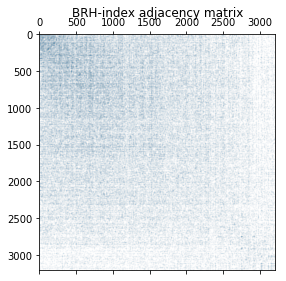

In [75]:
plt.spy(adjacency_brh_no_comp, markersize=0.01)
plt.title('BRH-index adjacency matrix');
plt.tight_layout()

## 4.4.1 Biggest component
[Back to index](#Index)

In [76]:
bc_nparray_brh_no_comp, nodes_bc_brh_no_comp = compute_bc('bc_nparray_no_comp.npy', adjacency_brh_no_comp)

In [77]:
n_nodes_bc_brh_no_comp = len(nodes_bc_brh_no_comp)

print('The size of the largest component is {}.'.format(n_nodes_bc_brh_no_comp))

The size of the largest component is 3178.


In [78]:
G_brh_no_comp = nx.from_numpy_array(bc_nparray_brh_no_comp)

print('Clustering coefficient of our Biggest Component = ' ,nx.average_clustering(G_brh_no_comp))

Clustering coefficient of our Biggest Component =  0.29440302253419576


In [79]:
movies_bc_brh_no_comp = movies_no_comp.loc[nodes_bc_brh_no_comp, :]
movies_bc_brh_no_comp['earnings'].describe()

count     3178.000000
mean        10.196851
std        241.311362
min         -0.999744
25%          0.030190
50%          1.301077
75%          3.396980
max      12889.386667
Name: earnings, dtype: float64

## 4.4.2 Graph visualisation on eigenmaps
[Back to index](#Index)

In [80]:
degree_biggest_component_brh_no_comp= np.sum(bc_nparray_brh_no_comp, axis=0)

N_brh_no_comp = n_nodes_bc_brh_no_comp  # number of nodes
E_brh_no_comp = np.sum(bc_nparray_brh_no_comp > 0)  # number of edges (non-zero entries of A)

sparse_gradient_brh_no_comp, sparse_laplacian_brh_no_comp = compute_gradient_laplacian('gradient_brh_no_comp.npz', bc_nparray_brh_no_comp, degree_biggest_component_brh_no_comp, N_brh_no_comp, E_brh_no_comp)

In [81]:
eigenvalues_brh_no_comp, eigenvectors_brh_no_comp = np.linalg.eigh(sparse_laplacian_brh_no_comp.toarray())
e_brh_no_comp = eigenvalues_brh_no_comp
U_brh_no_comp = eigenvectors_brh_no_comp

D_brh_no_comp = np.diag(degree_biggest_component_brh_no_comp)
D_inv_brh_no_comp = np.divide(1,D_brh_no_comp)
D_inv_brh_no_comp[D_inv_brh_no_comp == np.inf] = 0
D_sqrtinv_brh_no_comp = scipy.linalg.sqrtm(D_inv_brh_no_comp)

#Renormalized by the degrees
U_norm_brh_no_comp = D_sqrtinv_brh_no_comp@U_brh_no_comp

# Normalize the rows of U_norm
rows_norm_brh_no_comp = np.linalg.norm(U_norm_brh_no_comp, axis=1, ord=2)
U_norm_brh_no_comp = (U_norm_brh_no_comp.T / rows_norm_brh_no_comp).T

/home/benoit/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


/home/benoit/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


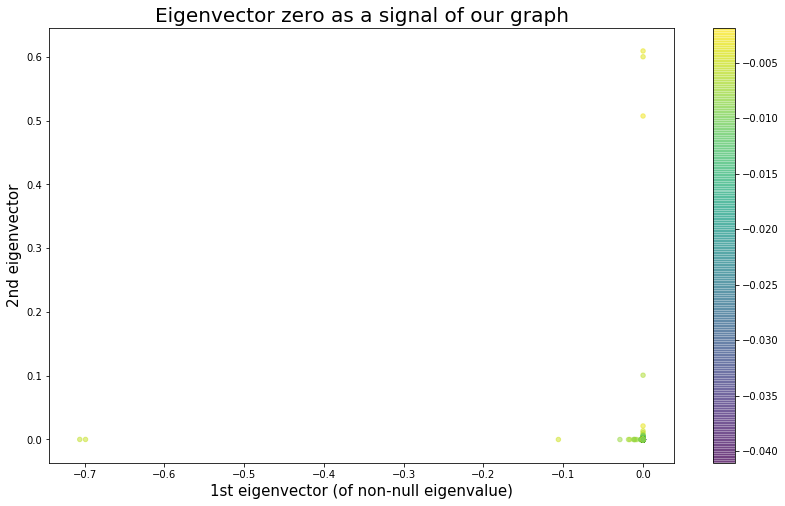

In [82]:
plt.figure(figsize=(14,8))
coords = U_norm_brh_no_comp[:,1:3]
nx_nodes = nx.draw_networkx_nodes(G_brh_no_comp, coords,alpha=0.5, node_size=20, node_color=U_norm_brh_no_comp[:,0])
nx.draw_networkx_edges(G_brh_no_comp, coords, alpha=0.0001)
plt.title('Eigenvector zero as a signal of our graph', fontsize=20)
plt.xlabel('1st eigenvector (of non-null eigenvalue)', fontsize=15)
plt.ylabel('2nd eigenvector', fontsize=15)
plt.colorbar(nx_nodes);

### Signal creation

In [83]:
label_threshold = 4

In [84]:
#Creation of binary labels, depending on the "earning threshold"
def labels_creation_brh_no_comp(threshold):
    labels = np.zeros(n_nodes_bc_brh_no_comp, dtype=float)
    labels[movies_bc_brh_no_comp['earnings'] >= threshold] = 1
    labels[movies_bc_brh_no_comp['earnings'] < threshold] = -1
    return labels

In [85]:
labels_bc_brh_no_comp = labels_creation_brh_no_comp(label_threshold)
lab_bc_count_brh_no_comp = np.unique(labels_bc_brh_no_comp, return_counts=True)
dict(zip(lab_bc_count_brh_no_comp[0], lab_bc_count_brh_no_comp[1]))

{-1.0: 2499, 1.0: 679}

<StemContainer object of 3 artists>

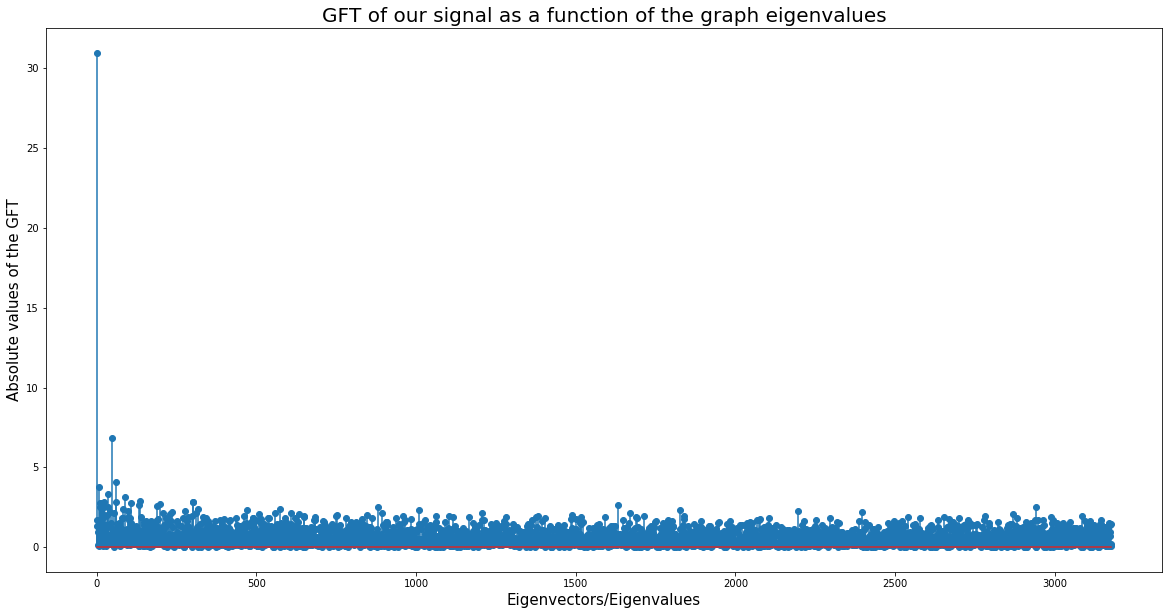

In [86]:
gft = GFT(labels_bc_brh_no_comp, N_brh_no_comp, U_norm_brh_no_comp)

gft_abs = abs(gft)
plt.figure(figsize=(20,10))
plt.title('GFT of our signal as a function of the graph eigenvalues', fontsize=20)
plt.xlabel('Eigenvectors/Eigenvalues', fontsize=15)
plt.ylabel('Absolute values of the GFT', fontsize=15)

plt.stem(gft_abs)

# 4.4.3 Analysis
[Back to Index](#Index)

IL FAUT ICI ECRIRE QQCHSE

/home/benoit/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


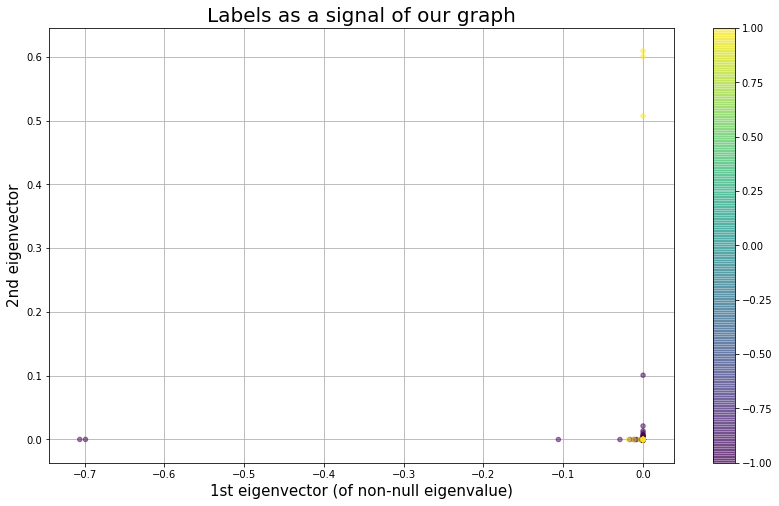

In [87]:
plt.figure(figsize=(14,8))
coords = U_norm_brh_no_comp[:,1:3]
nx_nodes = nx.draw_networkx_nodes(G_brh_no_comp, coords,alpha=0.5, node_size=20, node_color=labels_bc_brh_no_comp)
nx.draw_networkx_edges(G_brh_no_comp, coords, alpha=0.0001)
plt.title('Labels as a signal of our graph', fontsize=20)
plt.xlabel('1st eigenvector (of non-null eigenvalue)', fontsize=15)
plt.ylabel('2nd eigenvector', fontsize=15)
plt.colorbar(nx_nodes);
plt.grid()

In [88]:
# getting the indexes of the eigenvectors with the highest amplitude
index_eig = gft_abs.argsort()[-10:][::-1]
index_eig

array([  0,  49,  59,   7,  35,  89, 137, 302, 303,  60])

/home/benoit/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


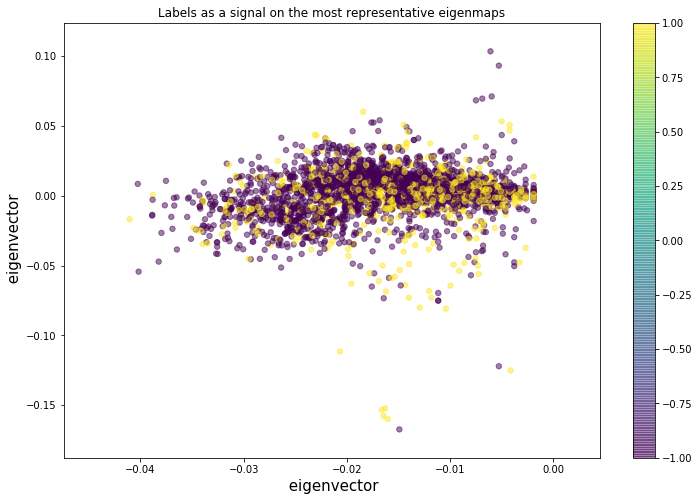

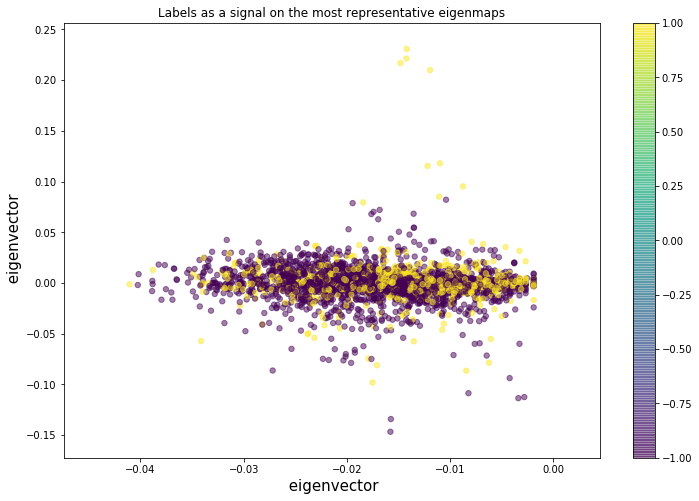

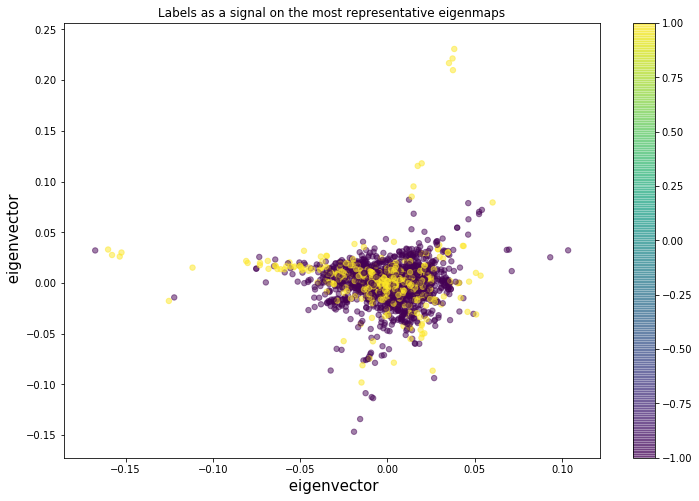

In [89]:
for i in range(3):
    for j in range(i+1,3):
        plt.figure(figsize=(12,8))
        coords = U_norm_brh_no_comp[:,[index_eig[i], index_eig[j]]]
        nx_nodes = nx.draw_networkx_nodes(G_brh_no_comp, coords,alpha=0.5 ,node_size=29, node_color=labels_bc_brh_no_comp)
        nx.draw_networkx_edges(G_brh_no_comp, coords, alpha=0.0001)
        plt.title('Labels as a signal on the most representative eigenmaps')
        plt.xlabel(' eigenvector', fontsize=15);
        plt.ylabel(' eigenvector', fontsize=15);
        plt.colorbar(nx_nodes);

## 4.5 Adjacency Matrix averaging BRH-index without companies
[Back to Index](#Index)

In [90]:
adjacency_brh_no_comp_avg = compute_adjacency('adjacency_brh_no_comp_avg.npy', 'brh_index', movies_no_comp, features_no_comp, True)

L_max = 5153655.0
L = 157300
Sparsity = 0.9694779724292759


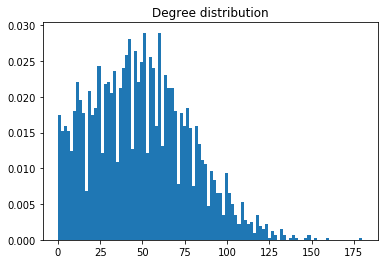

In [91]:
# maximum number of Links in our network
L_max_brh_no_comp_avg = n_nodes*(n_nodes-1)/2
print('L_max =', L_max_brh_no_comp_avg)

# number of link in our network
L_brh_no_comp_avg = np.count_nonzero(adjacency_brh_no_comp_avg)
print('L =',L_brh_no_comp_avg)

# sparisty
sparsity_brh_no_comp_avg = (L_max_brh_no_comp_avg-L_brh_no_comp_avg)/L_max_brh_no_comp_avg
print('Sparsity =', sparsity_brh_no_comp_avg)

# Create the binary version of adjacency matrix as our adjacency is weighted
adj_binary_brh_no_comp_avg = adjacency_brh_no_comp_avg.astype(bool).astype(int)
degree_brh_no_comp_avg =  np.sum(adj_binary_brh_no_comp_avg, axis=0)

#Histogram of degree distribution
weights_brh_no_comp_avg = np.ones_like(degree_brh_no_comp_avg) / float(n_nodes)
plt.hist(degree_brh_no_comp_avg, weights=weights_brh_no_comp_avg, bins = 100);
plt.title('Degree distribution');

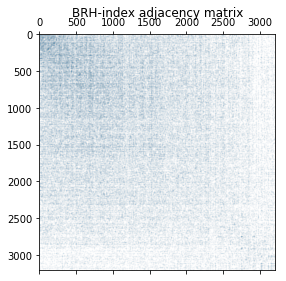

In [92]:
plt.spy(adjacency_brh_no_comp_avg, markersize=0.01)
plt.title('BRH-index adjacency matrix');
plt.tight_layout()

## 4.5.1 Biggest component
[Back to Index](#Index)

In [93]:
bc_nparray_brh_no_comp_avg, nodes_bc_brh_no_comp_avg = compute_bc('bc_nparray_no_comp_avg.npy', adjacency_brh_no_comp_avg)

In [94]:
n_nodes_bc_brh_no_comp_avg = len(nodes_bc_brh_no_comp_avg)

print('The size of the largest component is {}.'.format(n_nodes_bc_brh_no_comp_avg))

The size of the largest component is 3178.


In [95]:
G_brh_no_comp_avg = nx.from_numpy_array(bc_nparray_brh_no_comp_avg)

print('Clustering coefficient of our Biggest Component =' ,nx.average_clustering(G_brh_no_comp_avg))

Clustering coefficient of our Biggest Component = 0.29440302253419576


In [96]:
movies_bc_brh_no_comp_avg = movies_no_comp.loc[nodes_bc_brh_no_comp_avg, :]
movies_bc_brh_no_comp_avg['earnings'].describe()

count     3178.000000
mean        10.196851
std        241.311362
min         -0.999744
25%          0.030190
50%          1.301077
75%          3.396980
max      12889.386667
Name: earnings, dtype: float64

## 4.5.2 Graph visualisation on eigenmaps
[Back to Index](#Index)

In [97]:
degree_biggest_component_brh_no_comp_avg= np.sum(bc_nparray_brh_no_comp_avg, axis=0)

N_brh_no_comp_avg = n_nodes_bc_brh_no_comp_avg  # number of nodes
E_brh_no_comp_avg = np.sum(bc_nparray_brh_no_comp_avg > 0)  # number of edges (non-zero entries of A)

sparse_gradient_brh_no_comp_avg, sparse_laplacian_brh_no_comp_avg = compute_gradient_laplacian('gradient_brh_no_comp_avg.npz', bc_nparray_brh_no_comp_avg, degree_biggest_component_brh_no_comp_avg, N_brh_no_comp_avg, E_brh_no_comp_avg)

In [98]:
eigenvalues_brh_no_comp_avg, eigenvectors_brh_no_comp_avg = np.linalg.eigh(sparse_laplacian_brh_no_comp_avg.toarray())
e_brh_no_comp_avg = eigenvalues_brh_no_comp_avg
U_brh_no_comp_avg = eigenvectors_brh_no_comp_avg

D_brh_no_comp_avg = np.diag(degree_biggest_component_brh_no_comp_avg)
D_inv_brh_no_comp_avg = np.divide(1,D_brh_no_comp_avg)
D_inv_brh_no_comp_avg[D_inv_brh_no_comp_avg == np.inf] = 0
D_sqrtinv_brh_no_comp_avg = scipy.linalg.sqrtm(D_inv_brh_no_comp_avg)

#Renormalized by the degrees
U_norm_brh_no_comp_avg = D_sqrtinv_brh_no_comp_avg@U_brh_no_comp_avg

# Normalize the rows of U_norm
rows_norm_brh_no_comp_avg = np.linalg.norm(U_norm_brh_no_comp_avg, axis=1, ord=2)
U_norm_brh_no_comp_avg = (U_norm_brh_no_comp_avg.T / rows_norm_brh_no_comp_avg).T

/home/benoit/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


/home/benoit/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


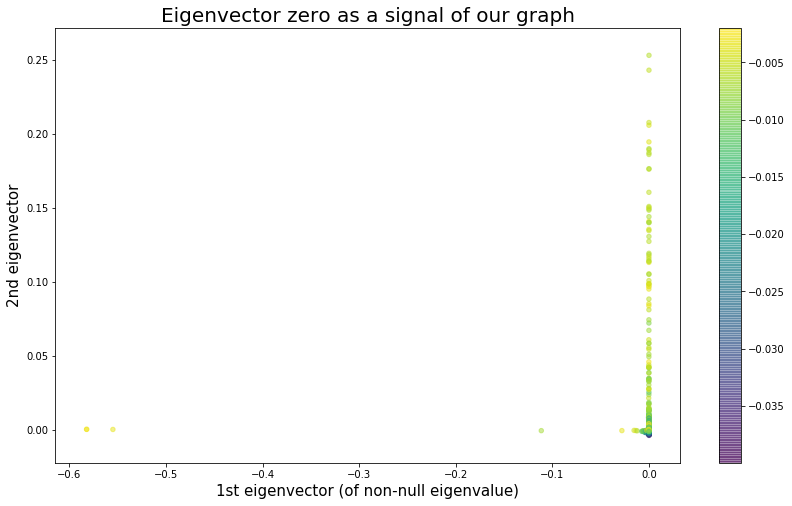

In [99]:
plt.figure(figsize=(14,8))
coords = U_norm_brh_no_comp_avg[:,1:3]
nx_nodes = nx.draw_networkx_nodes(G_brh_no_comp_avg, coords,alpha=0.5, node_size=20, node_color=U_norm_brh_no_comp_avg[:,0])
nx.draw_networkx_edges(G_brh_no_comp_avg, coords, alpha=0.0001)
plt.title('Eigenvector zero as a signal of our graph', fontsize=20)
plt.xlabel('1st eigenvector (of non-null eigenvalue)', fontsize=15)
plt.ylabel('2nd eigenvector', fontsize=15)
plt.colorbar(nx_nodes);

### Signal creation

In [100]:
label_threshold = 1

In [101]:
#Creation of binary labels, depending on the "earning threshold"
def labels_creation_brh_no_comp_avg(threshold):
    labels = np.zeros(n_nodes_bc_brh_no_comp_avg, dtype=float)
    labels[movies_bc_brh_no_comp_avg['earnings'] >= threshold] = 1
    labels[movies_bc_brh_no_comp_avg['earnings'] < threshold] = -1
    return labels

In [102]:
labels_bc_brh_no_comp_avg = labels_creation_brh_no_comp_avg(label_threshold)
lab_bc_count_brh_no_comp_avg = np.unique(labels_bc_brh_no_comp_avg, return_counts=True)
dict(zip(lab_bc_count_brh_no_comp_avg[0], lab_bc_count_brh_no_comp_avg[1]))

{-1.0: 1395, 1.0: 1783}

### Fourier Analysis

<StemContainer object of 3 artists>

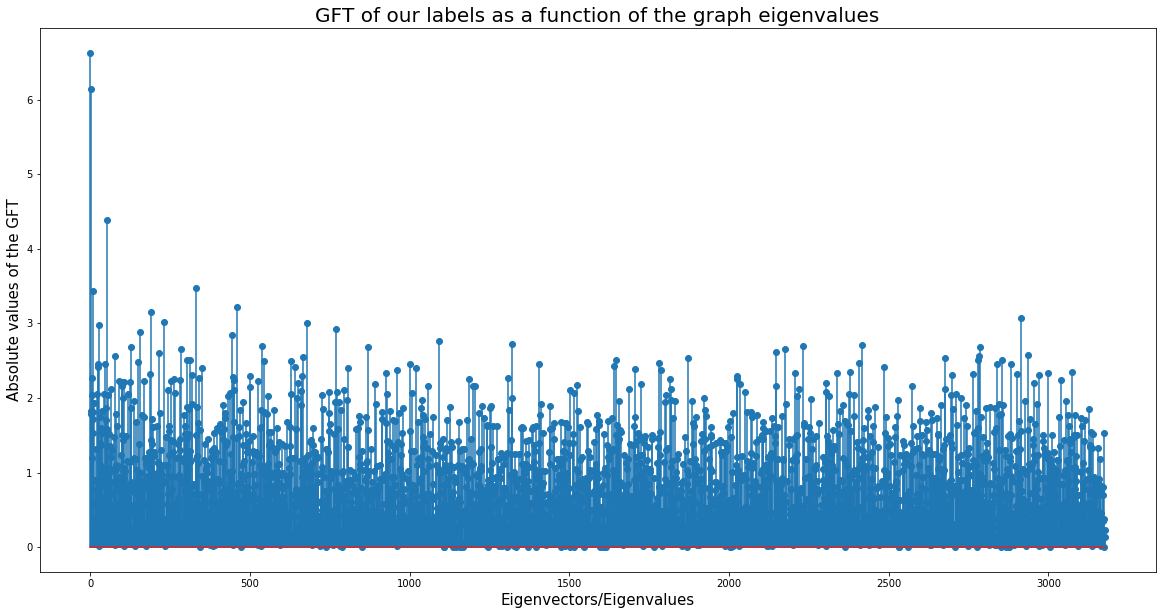

In [103]:
gft = GFT(labels_bc_brh_no_comp_avg, N_brh_no_comp_avg, U_norm_brh_no_comp_avg)

gft_abs = abs(gft)
plt.figure(figsize=(20,10))
plt.title('GFT of our labels as a function of the graph eigenvalues', fontsize=20)
plt.xlabel('Eigenvectors/Eigenvalues', fontsize=15)
plt.ylabel('Absolute values of the GFT', fontsize=15)

plt.stem(gft_abs)

In [104]:
index_eig = gft_abs.argsort()[-10:][::-1]

## 4.5.3 Analysis
[Back to Index](#Index)

/home/benoit/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


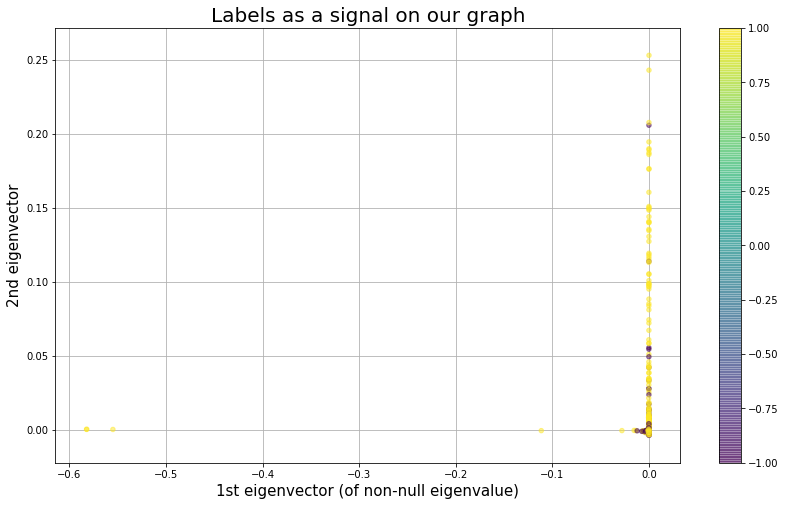

In [105]:
plt.figure(figsize=(14,8))
coords = U_norm_brh_no_comp_avg[:,1:3]
nx_nodes = nx.draw_networkx_nodes(G_brh_no_comp_avg, coords,alpha=0.5, node_size=20, node_color=labels_bc_brh_no_comp_avg)
nx.draw_networkx_edges(G_brh_no_comp_avg, coords, alpha=0.0001)
plt.title('Labels as a signal on our graph', fontsize=20)
plt.xlabel('1st eigenvector (of non-null eigenvalue)', fontsize=15)
plt.ylabel('2nd eigenvector', fontsize=15)
plt.colorbar(nx_nodes);
plt.grid()

/home/benoit/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


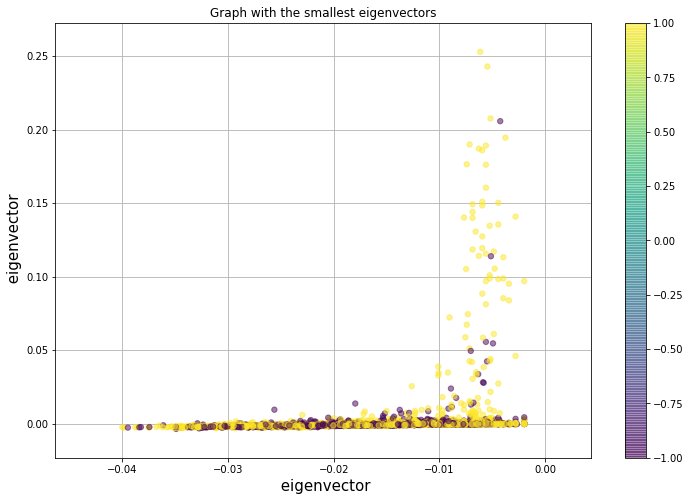

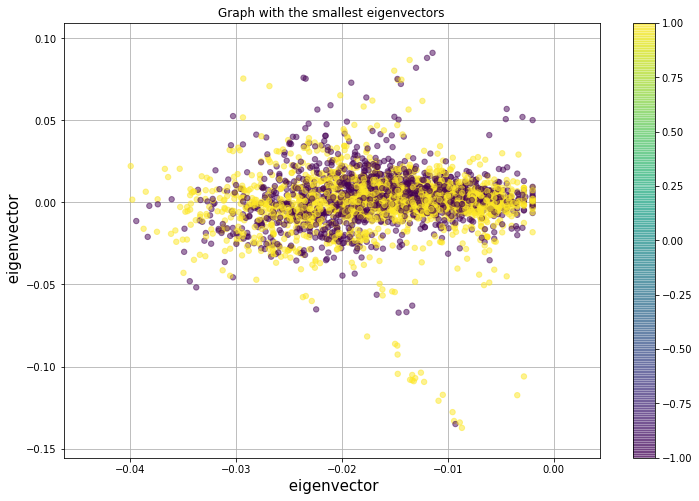

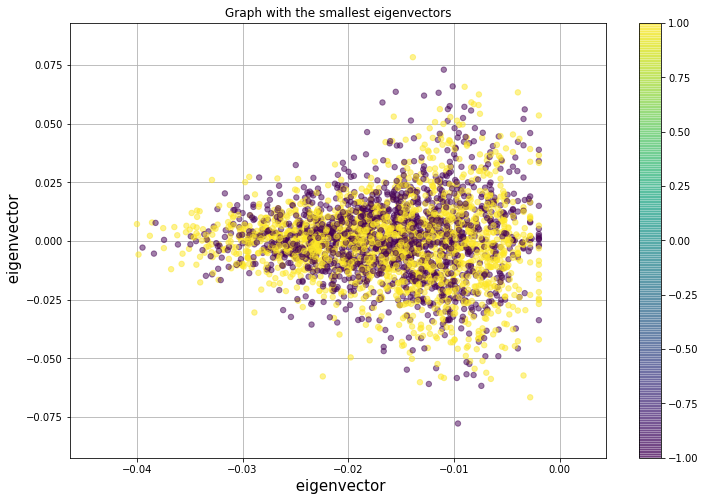

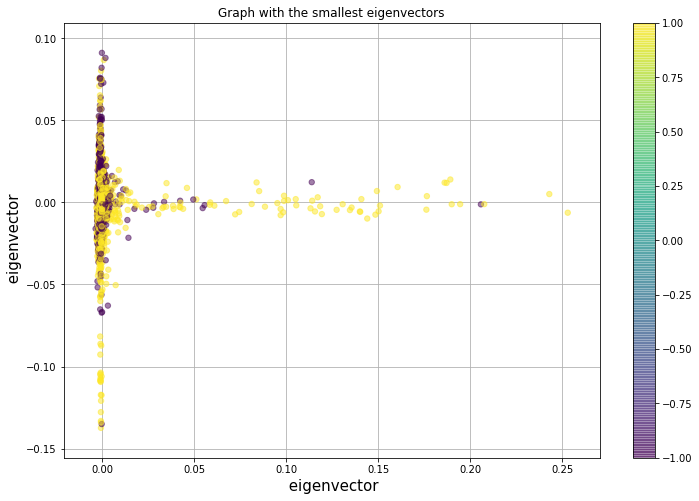

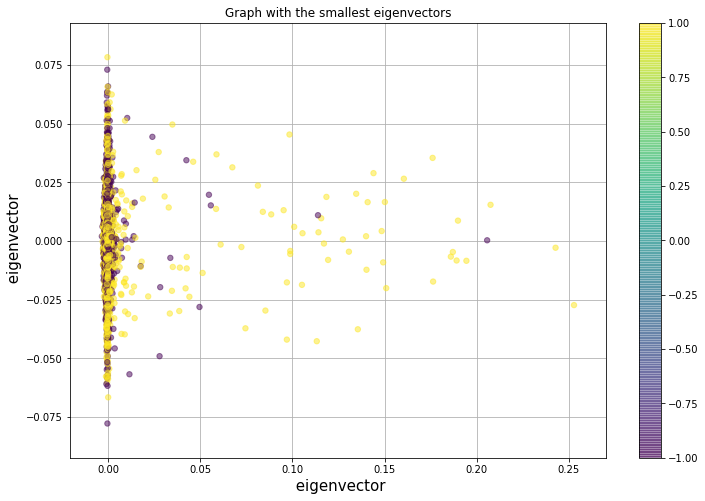

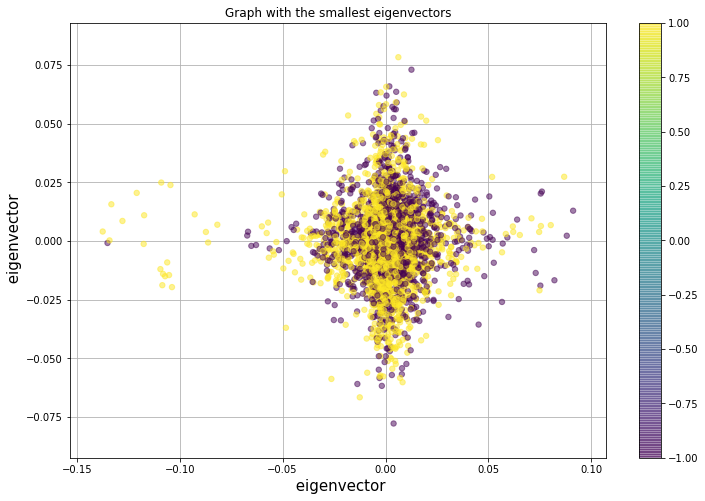

In [106]:
for i in range(4):
    for j in range(i+1,4):
        plt.figure(figsize=(12,8))
        coords = U_norm_brh_no_comp_avg[:,[index_eig[i], index_eig[j]]]
        nx_nodes = nx.draw_networkx_nodes(G_brh_no_comp_avg, coords,alpha=0.5 ,node_size=29, node_color=labels_bc_brh_no_comp_avg)
        nx.draw_networkx_edges(G_brh_no_comp_avg, coords, alpha=0.0001)
        plt.title('Graph with the smallest eigenvectors')
        plt.xlabel(' eigenvector', fontsize=15);
        plt.ylabel(' eigenvector', fontsize=15);
        plt.colorbar(nx_nodes);
        plt.grid()

In [107]:
# Manual check of which of the features are commun within cluster
list_of_list = np.argwhere(U_norm_brh_no_comp_avg[:,index_eig[2]]>0.01).tolist()
flat_list = [item for sublist in list_of_list for item in sublist]
cluster = movies_bc_brh_no_comp.iloc[flat_list]
cluster.head(10)

,original_title,earnings,features
3,The Dark Knight Rises,3.339756,"[Christian Bale, Michael Caine, Gary Oldman, A..."
4,John Carter,0.092843,"[Taylor Kitsch, Lynn Collins, Samantha Morton,..."
7,Avengers: Age of Ultron,4.019299,"[Robert Downey Jr., Chris Hemsworth, Mark Ruff..."
16,The Avengers,5.907081,"[Robert Downey Jr., Chris Evans, Mark Ruffalo,..."
18,Men in Black 3,1.773452,"[Will Smith, Tommy Lee Jones, Josh Brolin, Mic..."
24,King Kong,1.657005,"[Naomi Watts, Jack Black, Adrien Brody, Thomas..."
26,Captain America: Civil War,3.613218,"[Chris Evans, Robert Downey Jr., Scarlett Joha..."
31,Iron Man 3,5.077200,"[Robert Downey Jr., Gwyneth Paltrow, Don Chead..."
40,Cars 2,1.799262,"[Owen Wilson, Larry the Cable Guy, Michael Cai..."
58,Rush Hour 3,0.843016,"[Chris Tucker, Jackie Chan, Hiroyuki Sanada, M..."


In [108]:
cluster.describe()

,earnings
count,621.000000
mean,2.968840
std,12.550169
min,-0.999126
25%,-0.063733
50%,1.046671
75%,2.848268
max,249.000000


In [109]:
list_of_list = cluster.features.tolist()
flat_list = [item for sublist in list_of_list for item in sublist]
actors = pd.DataFrame(flat_list)
actors.columns = ['actor']
appearences = actors.actor.value_counts()
appearences

Matt Damon                          30
Robert Rodriguez                    30
Mel Gibson                          22
Owen Wilson                         21
Woody Harrelson                     21
Will Smith                          20
Angelina Jolie                      20
Michael Douglas                     20
Jackie Chan                         18
Gary Oldman                         18
Dwayne Johnson                      17
Vin Diesel                          17
Antonio Banderas                    17
Colin Farrell                       17
George Clooney                      17
Gerard Butler                       17
Sandra Bullock                      17
Reese Witherspoon                   16
Kevin Smith                         16
Jack Black                          16
Pierce Brosnan                      16
Elizabeth Banks                     15
Robert Downey Jr.                   15
Bruce Willis                        15
Jessica Alba                        14
Seann William Scott      